In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
df=pd.read_csv("/content/KEYACOSMET.csv",parse_dates=['DATE'])
df.head()

#       DATE TRADING CODE  LTP*  ...  YCP   TRADE  VALUE (mn)     VOLUME
0  439 2018-05-08   KEYACOSMET   8.2  ...  8.4  1134.0      52.501  6379892.0
1  438 2018-06-08   KEYACOSMET   8.2  ...  8.2   438.0       9.864  1192124.0
2  437 2018-07-08   KEYACOSMET   8.3  ...  8.3   444.0      13.265  1611182.0
3  436 2018-08-08   KEYACOSMET   8.2  ...  8.2   622.0      18.938  2319027.0
4  435 2018-09-08   KEYACOSMET   8.1  ...  8.1   639.0      16.136  1986366.0

[5 rows x 12 columns]

In [3]:
# Sort DataFrame by date
df = df.sort_values('DATE')

# Double check the result
df.head()

#       DATE TRADING CODE  LTP*  ...  YCP   TRADE  VALUE (mn)     VOLUME
36  403 2018-01-10   KEYACOSMET   7.9  ...  7.8   490.0      19.591  2483829.0
59  380 2018-01-11   KEYACOSMET   7.4  ...  7.3   256.0      10.276  1393138.0
37  402 2018-02-10   KEYACOSMET   7.7  ...  7.8   312.0       7.353   940931.0
79  360 2018-02-12   KEYACOSMET   7.4  ...  7.1   575.0      18.945  2593386.0
16  423 2018-03-09   KEYACOSMET   8.4  ...  8.1  1165.0      53.939  6456482.0

[5 rows x 12 columns]

In [5]:
df = df.set_index('DATE')
df['daily_ret'] = df['CLOSEP*'].pct_change()
df['daily_ret'] = df['daily_ret'].fillna(0.0)

In [6]:
df['volatility']= df['daily_ret'].rolling(window=21).std()
df['volatility'] = df['volatility'].fillna(0.0)

In [7]:
df['volatility'] = df['volatility']*100

In [8]:
import matplotlib.pyplot as plt 

In [9]:
df=df.reset_index()['volatility']

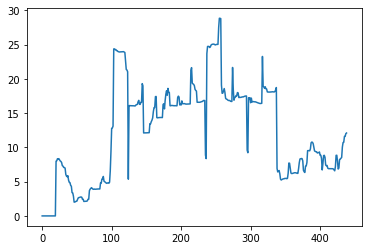

In [10]:
plt.plot(df)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [12]:
df.shape

(439, 1)

In [13]:

##splitting dataset into train and test split where train=70 percent and test=30 percent
training_size=int(len(df)*0.70)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]





In [14]:

training_size,test_size

(307, 132)

In [15]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [],[]
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:

print(X_train.shape), print(y_train.shape)

(206, 100)
(206,)


(None, None)

In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.optimizers import Adam

In [20]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:

model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
7/7 [==============================] - 9s 355ms/step - loss: 0.2428 - val_loss: 0.0484
Epoch 2/100
7/7 [==============================] - 1s 139ms/step - loss: 0.0443 - val_loss: 0.0042
Epoch 3/100
7/7 [==============================] - 1s 136ms/step - loss: 0.0315 - val_loss: 0.0270
Epoch 4/100
7/7 [==============================] - 1s 137ms/step - loss: 0.0251 - val_loss: 0.0256
Epoch 5/100
7/7 [==============================] - 1s 138ms/step - loss: 0.0227 - val_loss: 0.0173
Epoch 6/100
7/7 [==============================] - 1s 139ms/step - loss: 0.0213 - val_loss: 0.0359
Epoch 7/100
7/7 [==============================] - 1s 137ms/step - loss: 0.0206 - val_loss: 0.0271
Epoch 8/100
7/7 [==============================] - 1s 137ms/step - loss: 0.0193 - val_loss: 0.0284
Epoch 9/100
7/7 [==============================] - 1s 142ms/step - loss: 0.0205 - val_loss: 0.0338
Epoch 10/100
7/7 [==============================] - 1s 137ms/step - loss: 0.0202 - val_loss: 0.0346
Epoch 11/

In [22]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [23]:

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [24]:

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
X = np.reshape(ytest,(1, ytest.size))
Y_test =scaler.inverse_transform(X)

In [25]:
Y_test = Y_test.transpose()
RMSE = math.sqrt(mean_squared_error(Y_test,test_predict))
RMSE

5.724315288433914

In [26]:
Y_test

array([[ 8.55295729],
       [ 7.42381051],
       [ 7.32490438],
       [ 7.36939671],
       [ 6.97205917],
       [ 6.9000554 ],
       [ 6.9000554 ],
       [ 6.9000554 ],
       [ 6.9000554 ],
       [ 6.9000554 ],
       [ 6.9000554 ],
       [ 6.8906378 ],
       [ 6.85511448],
       [ 6.71035003],
       [ 6.58324035],
       [ 7.20730101],
       [ 8.84170518],
       [ 8.8550779 ],
       [ 7.97091156],
       [ 6.84492517],
       [ 6.99162419],
       [ 8.2532837 ],
       [ 8.29796855],
       [ 8.41609225],
       [ 8.54002649],
       [10.04364792],
       [10.7126318 ],
       [10.74833245],
       [11.60256381],
       [11.61200514],
       [12.00714087]])

In [27]:
test_predict

array([[13.649136],
       [13.793545],
       [13.743824],
       [13.595004],
       [13.446688],
       [13.287795],
       [13.151321],
       [13.059163],
       [13.01257 ],
       [13.002359],
       [13.01679 ],
       [13.045985],
       [13.080806],
       [13.113235],
       [13.126419],
       [13.117615],
       [13.181716],
       [13.484723],
       [13.870017],
       [14.09917 ],
       [14.045554],
       [13.881867],
       [13.873228],
       [13.965701],
       [14.102125],
       [14.244542],
       [14.561525],
       [15.003574],
       [15.414607],
       [15.834694],
       [16.16317 ]], dtype=float32)

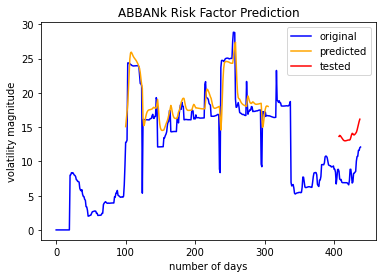

In [28]:

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df),color ='blue', label ='original')
plt.plot(trainPredictPlot, color ='orange', label ='predicted')
plt.plot(testPredictPlot , color ='red', label ='tested')
#plt.show()
plt.xlabel('number of days')
plt.ylabel('volatility magnitude')
plt.title('ABBANk Risk Factor Prediction')
plt.legend(loc='best')
plt.show(block=False)


In [29]:

x_input=test_data[32:].reshape(1,-1)
x_input.shape

(1, 100)

In [30]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [31]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)


[0.57491255]
101
1 day input [0.22553698 0.22950241 0.21292147 0.18583415 0.18165641 0.18406369
 0.18612588 0.18755151 0.18755151 0.18957036 0.18975404 0.18975404
 0.188293   0.1899556  0.21603956 0.26748149 0.26652177 0.24292615
 0.21679654 0.21429518 0.21470335 0.21585858 0.21663714 0.21834168
 0.21823458 0.21823458 0.21684261 0.21539188 0.21549072 0.23946263
 0.26937637 0.28808923 0.28922395 0.29030549 0.28974228 0.2787541
 0.23078335 0.22347823 0.21972949 0.25176315 0.25285999 0.27067927
 0.33019292 0.33030816 0.33043438 0.32938406 0.33901017 0.36963648
 0.37354409 0.37240922 0.36529196 0.34565391 0.32852463 0.32669274
 0.32455946 0.32455946 0.31844872 0.31959804 0.32050929 0.32360372
 0.30673894 0.30665911 0.29103026 0.23257716 0.26403388 0.3052173
 0.30659791 0.29639976 0.25726957 0.25384202 0.25538388 0.24161429
 0.23911902 0.23911902 0.23911902 0.23911902 0.23911902 0.23911902
 0.23879266 0.23756161 0.23254485 0.22813991 0.24976651 0.30640622
 0.30686965 0.27622917 0.2372085  0

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

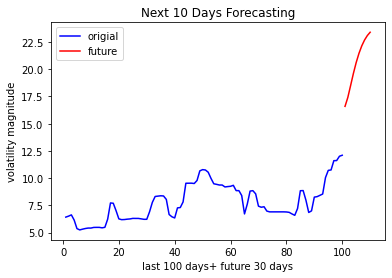

In [34]:

plt.plot(day_new,scaler.inverse_transform(df[339:]),color ='blue', label ='origial')
plt.plot(day_pred,scaler.inverse_transform(lst_output),color='red', label='future')
plt.xlabel('last 100 days+ future 30 days')
plt.ylabel('volatility magnitude')
plt.title('Next 10 Days Forecasting')
plt.legend(loc='best')
plt.show(block=False)

In [ ]:
df3=df.tolist()
df3.extend(lst_output)
plt.xlabel('last 100 days+ future 30 days')
plt.ylabel('volatility magnitude')
plt.title('Next 30 Days Forecasting')
plt.plot(df3[409:],color='red', label='future')
plt.legend(loc='best')
plt.show(block=False)

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

In [ ]:
plt.plot(df3)